In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import PCA


# Preprocessing mouse neurogenesis dataset

We aligned the raw reads from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116138) using STAR, and estimated the TPM per gene using RSEM. `SE_counts.tab.gz`, `rsem_gene_tpm.tab.gz`, `constitutive_introns.tab.gz` and `star_meta.tab.gz` were obtained using our pre-processing package [sc-splicing-tools](https://github.com/cfbuenabadn/sc_splicing_tools). 

Data normalization was performed with SCONE by running run_scone.R to obtain `scone_norm_tpm.tab.gz`.

In [2]:
norm_tpm = pd.read_csv('tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)

### Removing glial cells

This dataset contains a signficant number of outlier cells expressing glial cell markers.

Text(0, 0.5, 'PC 2')

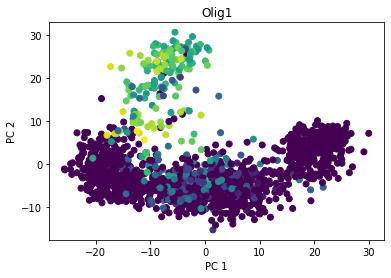

In [3]:
high_expression = norm_tpm.index[norm_tpm.mean(axis=1) > 2]
fano = (norm_tpm.loc[high_expression].var(axis=1)/norm_tpm.loc[high_expression].mean(axis=1)).sort_values()

pca_norm_tiklova = PCA(n_components=2)
pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm.loc[fano.index[-500:]].T)
plt.scatter(pca_norm_tiklova.T[0], pca_norm_tiklova.T[1], c=norm_tpm.loc['Olig1'])
plt.title('Olig1')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

We remove these cells before further analysis. 

In [4]:
glia = norm_tpm.columns[(norm_tpm.loc['Hepacam'] >= 1) | (norm_tpm.loc['Ednrb'] >= 1)  | (norm_tpm.loc['Olig1'] >= 1) | (norm_tpm.loc['Ramp1'] >= 1) | (norm_tpm.loc['Aldh1l1'] >= 1)]
neurogenesis_cells = [x for x in norm_tpm.columns if x not in glia]
norm_tpm_neuro = norm_tpm[neurogenesis_cells]

### High variable genes and dimensionality reduction

First we select genes with high expression. Out of these genes, we select the top 500 genes with the highest Fano factor and we perform dimensionality reduction with PCA. In this case, the fist two components explain by far most of the variance, with the first component being clearly associated to neuron development. We keep these two components for further analysis.

Text(0, 0.5, 'Explained variance')

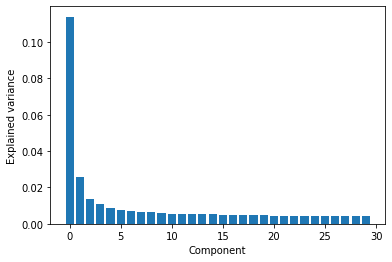

In [8]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 2]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)
pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[fano.index[-500:]].T)

plt.bar(range(30),pca_norm_tiklova.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance')

### Visualization of mouse brain development

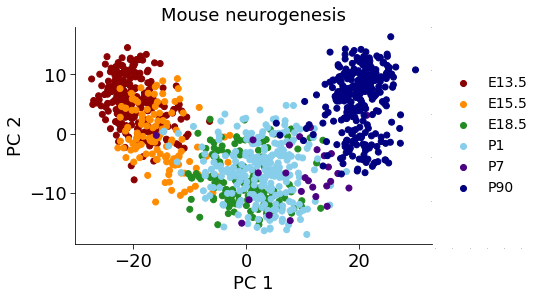

In [9]:
pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[fano.index[-500:]].T)

rd = pd.DataFrame()
for i in range(2):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = -rd.PC_2

meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(rd.PC_1, rd.PC_2, c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('Mouse neurogenesis', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='darkred', label='E13.5')
ax_2.scatter([0], [0], c='darkorange', label='E15.5')
ax_2.scatter([0], [0], c='forestgreen', label='E18.5')
ax_2.scatter([0], [0], c='skyblue', label='P1')
ax_2.scatter([0], [0], c='indigo', label='P7')
ax_2.scatter([0], [0], c='navy', label='P90')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

plt.savefig('../../plots/PCA_neurogenesis.png', bbox_inches='tight', res=100)
plt.savefig('../../plots/PCA_neurogenesis.svg', bbox_inches='tight')
plt.savefig('../../plots/PCA_neurogenesis.pdf', bbox_inches='tight')

Now we remove the low quality and glial cells from the rest of the data: exon splice junction reads, constitutive junction reads, and TPM counts. 

In [11]:
data_dir = '../pipeline_output/'
skipped_exons = pd.read_csv(data_dir + 'SE_counts.tab.gz', sep='\t', index_col=0)
tpm = pd.read_csv(data_dir + 'rsem_gene_tpm.tab.gz', sep='\t', index_col=0)
ci = pd.read_csv(data_dir + 'constitutive_introns.tab.gz', sep=',', index_col=0)

Save the curated data and the dimensionality reduction file.

In [79]:
ci[neurogenesis_cells].to_csv('tables/constitutive_introns_filtered.tab.gz', sep='\t', index=True, header=True)
skipped_exons[neurogenesis_cells].to_csv('tables/SE_counts_filtered.tab.gz', sep='\t', index=True, header=True)
tpm[neurogenesis_cells].to_csv('tables/rsem_gene_tpm_filtered.tab.gz', sep='\t', index=True, header=True)

rd[['PC_1', 'PC_2']].to_csv('tables/pc2_rd.tab.gz', sep='\t', index=True, header=True)

### Make tsv files for BRIE2 runs

After selecting quality neuron cells, we create files to run BRIE2 for method comparison. BRIE2 relies on cell annotations, and cell type vs cell type comparisons. Since there is not a clear linear relationship between the cell labels from this dataset, we run BRIE2 for each cell type vs the first.

In [4]:
rd = pd.read_csv('pc2_rd.tab.gz', sep='\t', index_col=0)
meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)
os.mkdir('brie2_files/')

In [27]:
def make_brie_files(meta, cells, cell_type1, cell_type2, name):
    fh_cells = open('brie2_files/cells_{name}.tsv'.format(name=name), 'w')
    fh_bam = open('brie2_files/bam_{name}.tsv'.format(name=name), 'w')
    fh_cells.write('cellID\tneuro\n')
    
    bam_loc = '/data/scratch/users/cfbuenabadn/Tiklova/RNASeq_pipeline_spike_replicate/{cell_id}_1/'
    bam_loc += 'star_output/Aligned.sortedByCoord.out.bam\t{cell_id}\n'
    
    meta = meta.loc[cells]
    cells_1 = meta.loc[meta.Age == cell_type1].index
    cells_2 = meta.loc[meta.Age == cell_type2].index
    
    for cell in cells_1:
        fh_cells.write(cell +'\t0\n')
        fh_bam.write(bam_loc.format(cell_id=cell))
        
    for cell in cells_2:
        fh_cells.write(cell +'\t1\n')
        fh_bam.write(bam_loc.format(cell_id=cell))
        
    fh_cells.close()
    fh_bam.close()
    

In [28]:
make_brie_files(meta, rd.index, 'embryonic day 13.5', 'embryonic day 15.5', 'E13_v_E15')
make_brie_files(meta, rd.index, 'embryonic day 13.5', 'embryonic day 18.5', 'E13_v_E18')
make_brie_files(meta, rd.index, 'embryonic day 13.5', 'postnatal day 1', 'E13_v_P1')
make_brie_files(meta, rd.index, 'embryonic day 13.5', 'postnatal day 7', 'E13_v_P7')
make_brie_files(meta, rd.index, 'embryonic day 13.5', 'postnatal day 90', 'E13_v_P90')